# ml_lstm: End-to-end CLI workflow (ingestion òÆÒ paper trading)
This notebook collects the major project CLIs needed to run the full workflow from data ingestion to paper trading.High-level steps:
1. Run the daily data pipeline (ingestion, cleaning, gap handling, feature engineering).
2. Train the LSTM model.
3. Evaluate the latest best model.
4. Generate per-bar predictions CSV.
5. Run a backtest using that CSV.
6. Plot backtest diagnostics.
7. Run simulated paper trading using the same CSV.All `!` shell commands assume this notebook is in `notebooks/` and the project root is the parent directory.

In [1]:
import sys
import subprocess
from pathlib import Path
import importlib

project_root = Path().resolve().parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import src.config as cfg
cfg = importlib.reload(cfg)

from src.config import (
    get_predictions_csv_path,
    get_trades_csv_path,
    get_equity_csv_path,
    get_hourly_data_csv_path,
)

FREQUENCY = cfg.FREQUENCY
TSTEPS = cfg.TSTEPS

PREDICTIONS_CSV = get_predictions_csv_path('nvda', FREQUENCY)
TRADES_CSV = get_trades_csv_path('nvda', FREQUENCY)
EQUITY_CSV = get_equity_csv_path('nvda', FREQUENCY)
PRICE_CSV = get_hourly_data_csv_path(FREQUENCY)

print('Using FREQUENCY =', FREQUENCY, 'TSTEPS =', TSTEPS)
print('PREDICTIONS_CSV =', PREDICTIONS_CSV)
print('TRADES_CSV      =', TRADES_CSV)
print('EQUITY_CSV      =', EQUITY_CSV)
print('PRICE_CSV       =', PRICE_CSV)


def run_module(mod, *args):
    cmd = [sys.executable, '-m', mod, *map(str, args)]
    print('Running:', ' '.join(cmd), 'in', project_root)
    result = subprocess.run(cmd, cwd=project_root, check=False)
    if result.returncode != 0:
        print(f'Command failed with exit code {result.returncode}')
    return result.returncode


Using FREQUENCY = 15min TSTEPS = 5
PREDICTIONS_CSV = C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_predictions.csv
TRADES_CSV      = C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_trades.csv
EQUITY_CSV      = C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_equity.csv
PRICE_CSV       = C:\Users\Anton\SRC\my\ml_lstm\data\processed\nvda_15min.csv


In [2]:
import sys
import subprocess

subprocess.run([sys.executable, '-m', 'pip', 'install', 'tqdm'], check=False)


CompletedProcess(args=['C:\\Users\\Anton\\SRC\\my\\ml_lstm\\venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'tqdm'], returncode=0)

## 1. Daily data pipeline 
(ingestion processed hourly features)Runs `src.daily_data_agent` which orchestrates ingestion, cleaning, gap handling, curated minute snapshot, and resampling + feature engineering.

In [7]:
# Run the daily data pipeline (ingestion -> processed features). For a dry run that skips IB/TWS ingestion, add '--skip-ingestion' to the arguments below. 
run_module('src.daily_data_agent')

Running: C:\Users\Anton\SRC\my\ml_lstm\venv\Scripts\python.exe -m src.daily_data_agent in C:\Users\Anton\SRC\my\ml_lstm


0

## 2. Train LSTM model

In [20]:
# Train an LSTM model for the chosen FREQUENCY and TSTEPS using src.train. 
run_module('src.train', '--frequency', FREQUENCY, '--tsteps', TSTEPS)

Running: C:\Users\Anton\SRC\my\ml_lstm\venv\Scripts\python.exe -m src.train --frequency 15min --tsteps 5 in C:\Users\Anton\SRC\my\ml_lstm


0

## 3. Evaluate latest best modelEvaluate the latest best model (based on `best_hyperparameters.json`) using `src.evaluate_model`.

In [8]:
# Evaluate the latest best model using src.evaluate_model. 
run_module('src.evaluate_model')

Running: C:\Users\Anton\SRC\my\ml_lstm\venv\Scripts\python.exe -m src.evaluate_model in C:\Users\Anton\SRC\my\ml_lstm


0

## 4. Generate per-bar predictions CSV
Use `scripts.generate_predictions_csv` to create a per-bar predictions file for NVDA at the chosen `FREQUENCY`.Output columns: `Time`, `predicted_price`.

In [22]:
# Generate per-bar predictions CSV for NVDA at the chosen FREQUENCY. 
run_module('scripts.generate_predictions_csv', '--frequency', FREQUENCY, '--output', PREDICTIONS_CSV)

Running: C:\Users\Anton\SRC\my\ml_lstm\venv\Scripts\python.exe -m scripts.generate_predictions_csv --frequency 15min --output C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_predictions.csv in C:\Users\Anton\SRC\my\ml_lstm


0

## 5. Run backtest using predictions CSV
Run `src.backtest` over processed OHLC data, using the predictions CSV as the prediction source.- `--prediction-mode csv` tells the backtest to read `predicted_price` from the CSV.- Exports trades and equity curve CSVs for diagnostics.

In [23]:
# Run a backtest over processed OHLC data using the predictions CSV. 
run_module('src.backtest', 
           '--frequency', FREQUENCY, 
           '--prediction-mode','csv',
           '--predictions-csv', PREDICTIONS_CSV,
           '--export-trades-csv', TRADES_CSV,
           '--export-equity-csv', EQUITY_CSV)

Running: C:\Users\Anton\SRC\my\ml_lstm\venv\Scripts\python.exe -m src.backtest --frequency 15min --prediction-mode csv --predictions-csv C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_predictions.csv --export-trades-csv C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_trades.csv --export-equity-csv C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_equity.csv in C:\Users\Anton\SRC\my\ml_lstm


0

## 6. Plot backtest diagnostics
Use `scripts.plot_backtest_diagnostics` to visualize equity curve and trade entry density.

In [24]:
from pathlib import Path
from scripts.plot_backtest_diagnostics import plot_equity_and_trade_density
from src.config import (
    FREQUENCY,
    get_equity_csv_path,
    get_trades_csv_path,
    get_hourly_data_csv_path,
)

project_root = Path().resolve().parent

equity_path = project_root / get_equity_csv_path("nvda", FREQUENCY)
trades_path = project_root / get_trades_csv_path("nvda", FREQUENCY)
price_path = project_root / get_hourly_data_csv_path(FREQUENCY)

print("Equity CSV:", equity_path, "exists:", equity_path.exists())
print("Trades CSV:", trades_path, "exists:", trades_path.exists())
print("Price CSV:", price_path, "exists:", price_path.exists())

plot_equity_and_trade_density(
    equity_path=str(equity_path),
    trades_path=str(trades_path),
    price_csv_path=str(price_path),
)

Equity CSV: C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_equity.csv exists: True
Trades CSV: C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_15min_trades.csv exists: True
Price CSV: C:\Users\Anton\SRC\my\ml_lstm\data\processed\nvda_15min.csv exists: True
Saved diagnostics plot to backtests\backtest_diagnostics.png


## 7. Paper trading over historical data
Use `src.paper_trade` to run a simulated paper-trading session over historical NVDA data, reusing the predictions CSV.

In [25]:
!cd .. && python -m src.paper_trade --frequency {FREQUENCY} --predictions-csv {PREDICTIONS_CSV}

[paper] Session summary
Frequency:      15min
Start date:     2022-12-30 11:00:00
End date:       2025-11-24 17:15:00
Initial equity: 10000.00
Final equity:   3964.94
Trades:         420
Saved backtest plot to backtests\NVDA-15min-0.10-1.00-0.0200-2.50-20221230-20251124.png


## 8. (Optional) Hyperparameter tuning and experiment grid
Not required for the minimal ingestion òÆÒ paper-trading loop, but useful for experimentation.

In [ ]:
# Optional: run hyperparameter tuning (can be long-running)#
!cd .. && python -m src.tune_hyperparameters

# Optional: run a grid of experiments (very long-running)# 
!cd .. && python -m src.experiment_runner

#Plot 15mins data

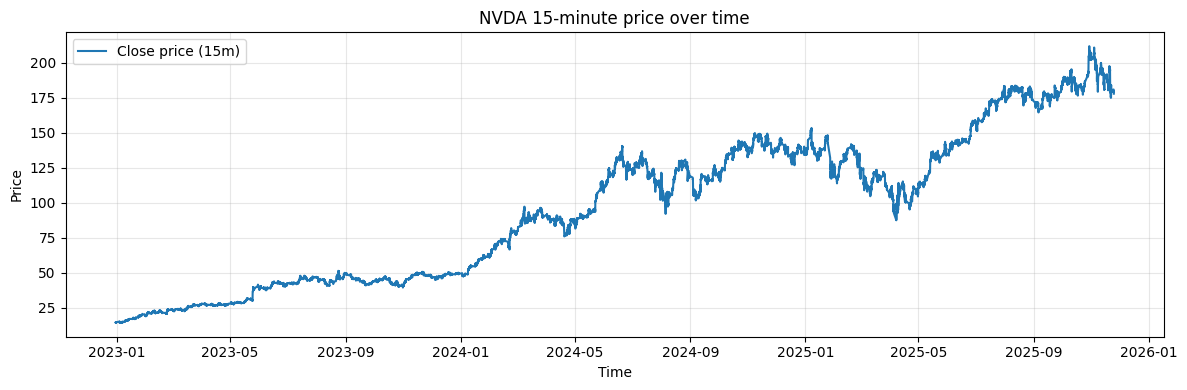

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# PRICE_CSV is already defined in the first cell of this notebook
price_path = Path(PRICE_CSV)

# Load the 15‑minute OHLC data
prices = pd.read_csv(price_path)

# Ensure we have a proper datetime column
prices["Time"] = pd.to_datetime(prices["Time"])
prices = prices.sort_values("Time")

# Choose which price to plot (use 'Close' if available)
price_col = "Close" if "Close" in prices.columns else prices.columns[1]

plt.figure(figsize=(12, 4))
plt.plot(prices["Time"], prices[price_col], label=f"{price_col} price (15m)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("NVDA 15‑minute price over time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()